<center>Jaemin Son, 2018320192</center><br>

# Reading Data

In [1]:
import sys
sys.path.insert(0, '..')
%matplotlib inline
import d2l
import torch
import torch.nn as nn
import numpy as np
import time

In [2]:
def get_data():
    data = np.genfromtxt('../data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.Tensor(data[:1500, :-1]), torch.Tensor(data[:1500, -1])

features, labels =get_data()
features.shape

torch.Size([1500, 5])

# Implementation from Scratch

In [3]:
def sgd(params, states, hyperparams,batch_size):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [4]:
def train(trainer_fn, states, hyperparams, features, labels,batch_size=10, num_epochs=2):
    
    # Initialize model parameters
    net, loss = d2l.linreg, d2l.squared_loss
    w= torch.rand((features.shape[1], 1), requires_grad=True)
    b= torch.zeros((1,),requires_grad=True)
    l= torch.zeros((1500,1),requires_grad=True)
    def eval_loss():
        return loss(net(features, w, b), labels).mean()
    ls, ts = [eval_loss()], [0,]
    data_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)
    start = time.time()
    for _ in range(num_epochs):
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(torch.mm(X,w)+b,y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams,batch_size)
            if (batch_i + 1) * batch_size % 10 == 0:
                ts.append(time.time() - start + ts[-1])
                ls.append(eval_loss())
                start = time.time()
    print('loss: %f, %f sec per epoch' % (ls[-1], ts[-1]/num_epochs))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')
    return ts, ls

loss: 0.305600, 0.028192 sec per epoch


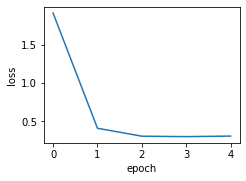

In [5]:
def train_sgd(lr, batch_size, num_epochs=2):
    return train(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)
gd_res = train_sgd(1, 1500,4)

loss: 0.246820, 0.280019 sec per epoch


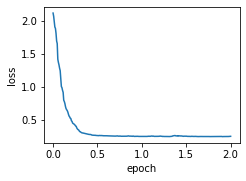

In [6]:
sgd_res = train_sgd(0.005, 1)

loss: 0.245103, 0.010971 sec per epoch


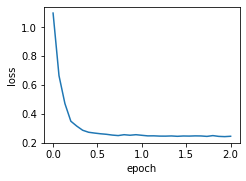

In [7]:
mini1_res = train_sgd(.4, 100)

loss: 0.244108, 0.035439 sec per epoch


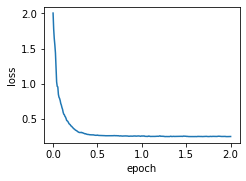

In [8]:
mini2_res = train_sgd(.05, 10)

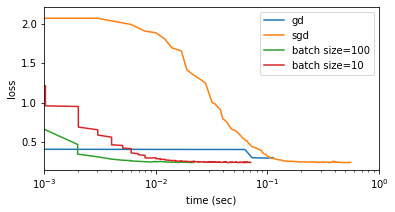

In [9]:
d2l.set_figsize([6, 3])
for res in [gd_res, sgd_res, mini1_res, mini2_res]:
    d2l.plt.plot(res[0], res[1])
    d2l.plt.xlabel('time (sec)')
    d2l.plt.ylabel('loss')
    d2l.plt.xscale('log')
    d2l.plt.xlim([1e-3, 1])
    d2l.plt.legend(['gd', 'sgd', 'batch size=100', 'batch size=10']);

# Discussions
1. For Mini-batch stochastic gradient descent algorithm, smaller batch size makes it more inefficient to train; it requires more computation for one epoch.
2. My experiment result says that gradient descent algorithm changes for every experiments. What makes this variation since data is unchanged?
    - Found the reason that it was because the initial weight was set randomly.